In [2]:
Hosts=["Mycobacterium"]
paccs=[]
phage_info=open("./data/top_host_phage_info.txt")
for line in phage_info.readlines():
    host=line.split("\t")[0]
    trna_count=line.split("\t")[-3]
    name=line.split("\t")[3]
    if host in Hosts and int(trna_count)>0:
        paccs.append(line.split("\t")[2])

In [3]:
import os
from Bio import SeqIO
import subprocess

smegs=[]

for phage in paccs:
    gbk_file="./data/pgenomes/"+phage+".gbk"
    if os.path.exists(gbk_file):
        handle=SeqIO.parse(gbk_file, "genbank")

        for g in handle:
                for feature in g.features:
                    if feature.type=="source":
                        if "host" in feature.qualifiers.keys():
                            hostish=(feature.qualifiers["host"][0])
                        elif "lab_host" in feature.qualifiers.keys():
                            hostish=(feature.qualifiers["lab_host"][0]+"***")
                        elif "isolate" in feature.qualifiers.keys():
                            hostish=(feature.qualifiers["isolate"][0])
                            #print(feature.qualifiers)
                        else:
                            hostish="none"
                            #print("no host specified for "+phage)
                            #print(feature.qualifiers)
        if "155" in hostish:
            smegs.append(phage)
        
print(len(smegs))

87


In [31]:
from Bio import SeqIO
import subprocess
import os

## now extract all CDS from genbank file:
def gbk_to_cds_fasta(gbk, output):
    handle=SeqIO.parse(gbk,"genbank")
    output=open(output,"w")
    count=0
    for g in handle:
        for feature in g.features:
            if feature.type=="CDS":
                count=count+1
                if "locus_tag" in feature.qualifiers.keys():
                    feature_name=feature.qualifiers["locus_tag"]
                elif "gene" in feature.qualifiers.keys(): 
                    feature_name=feature.qualifiers["gene"]
                else:
                    feature_name=feature.qualifiers["product"]
                feature_seq=feature.extract(g.seq)
                output.write(">"+str(feature_name)+"\n"+str(feature_seq)+"\n")
    print(str(count)+ " CDS sequences extracted from "+gbk)
    output.close()

def gbk_to_fasta(gbk, output):
    SeqIO.convert(gbk,"gb",output,"fasta")
    
def run_codonM(fasta, output):
    subprocess.call(["perl","./scripts/codonR/codonM",fasta,output])
    
def run_trna_scan(input_file, output):
    args=["tRNAscan-SE", "-o", output, "-G", "-D","-N", input_file]
    subprocess.call(args)
    print("tRNA scan of "+input_file+" is done!")

In [36]:
#os.mkdir("./data/pgenomes/MSmeg_phages")
path="./data/pgenomes/MSmeg_phages/"

for i in smegs:
    gbk_file="./data/pgenomes/"+i+".gbk"
    fasta=path+i+".fasta"
    cds_fasta=path+i+".cds.fasta"
    trna=path+i+".trna"
    gbk_to_cds_fasta(gbk_file,cds_fasta)
    gbk_to_fasta(gbk_file, fasta)
    run_trna_scan(fasta, trna)

97 CDS sequences extracted from ./data/pgenomes/JN049605.1.gbk
tRNA scan of ./data/pgenomes/MSmeg_phages/JN049605.1.fasta is done!
86 CDS sequences extracted from ./data/pgenomes/JN408459.1.gbk
tRNA scan of ./data/pgenomes/MSmeg_phages/JN408459.1.fasta is done!
143 CDS sequences extracted from ./data/pgenomes/JN391441.1.gbk
tRNA scan of ./data/pgenomes/MSmeg_phages/JN391441.1.fasta is done!
89 CDS sequences extracted from ./data/pgenomes/KM101119.1.gbk
tRNA scan of ./data/pgenomes/MSmeg_phages/KM101119.1.fasta is done!
145 CDS sequences extracted from ./data/pgenomes/JN412590.1.gbk
tRNA scan of ./data/pgenomes/MSmeg_phages/JN412590.1.fasta is done!
137 CDS sequences extracted from ./data/pgenomes/JN600672.1.gbk
tRNA scan of ./data/pgenomes/MSmeg_phages/JN600672.1.fasta is done!
153 CDS sequences extracted from ./data/pgenomes/JF937105.1.gbk
tRNA scan of ./data/pgenomes/MSmeg_phages/JF937105.1.fasta is done!
231 CDS sequences extracted from ./data/pgenomes/JN204348.1.gbk
tRNA scan of ./

In [4]:
%load_ext rpy2.ipython
%R library(dplyr); library(magrittr); library(ggplot2); library(reshape)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Need help? Try the ggplot2 mailing list: http://groups.google.com/group/ggplot2.

Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename



In [38]:
%%R
##Functions:

source("./scripts/codonR/tAI.R")

#need file: "./data/codon_list.txt"
#must create codonm files using codonm.pl and .trna files using tRNAscanSE for phages and for the host
#must have host genome as a fasta file of cds sequences


tscan_to_list<-function (tscanfile, codon_list="./data/codon_list.txt"){
    codons=read.table(codon_list, header=FALSE)
    trnas=read.table(tscanfile, sep="\t", skip=3, header=FALSE)%>%group_by(V6)%>%summarise(count=n())
    codons$count<-trnas$count[match(codons$V2, trnas$V6)]
    codons[is.na(codons)]<-0
    return(codons$count)
    }

ph_tscan_to_list<-function(host_tscan, phage_tscan, codon_list="./data/codon_list.txt"){
    codons=read.table(codon_list)
    h=read.table(host_tscan, sep="\t", skip=3, header=FALSE)%>%group_by(V6)%>%summarise(count=n())
    p=read.table(phage_tscan, sep="\t", skip=3, header=FALSE)%>%group_by(V6)%>%summarise(count=n())
    codons$h<-h$count[match(codons$V2, h$V6)]
    codons$p<-p$count[match(codons$V2, p$V6)]
    codons[is.na(codons)]<-0
    codons<-mutate(codons, count=h+p)
    return(codons$count)
}

calculate_ph_tais<-function(htrna, ptrna, codonM_file){
    h.trna<-tscan_to_list(htrna)
    ph.trna<-ph_tscan_to_list(htrna, ptrna)
    
    h.ws<-get.ws(tRNA=h.trna, sking=1)
    ph.ws<-get.ws(tRNA=ph.trna, sking=1)
    
    
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    
    h.tai<-get.tai(h.m, h.ws)
    ph.tai<-get.tai(h.m, ph.ws)
    
    return(cbind.data.frame(h.tai, ph.tai))
}

calculate_ph_tai<-function(htrna, ptrna, codonM_file){
    h.trna<-tscan_to_list(htrna)
    ph.trna<-ph_tscan_to_list(htrna, ptrna)
    h.ws<-get.ws(tRNA=h.trna, sking=1)
    ph.ws<-get.ws(tRNA=ph.trna, sking=1)
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    ph.tai<-get.tai(h.m, ph.ws)
    
    return(ph.tai)
}

calculate_tai<-function(trna, codonM_file){
    h.trna<-tscan_to_list(trna)
    h.ws<-get.ws(tRNA=h.trna, sking=1)
    print("scanning codonM file")
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    h.tai<-get.tai(h.m, h.ws)
    return(h.tai)
}

#modified from dos Reis... not used in below calculations.
get.ws.phage <- function(tRNA,   # tRNA gene copy number
                         h.ws,   # host ws after sending host tRNA list through get.ws
                   s = ops,      # selective constraints determined by dos Reis 2004
                   sking) # super kingdom: 0-eukaryota, 1-prokaryota
{

  p = 1 - s

  # initialise w vector
  W = NULL  # don't confuse w (lowercase) and W (uppercase)

  # obtain absolute adaptiveness values (Ws)
  for (i in seq(1, 61, by=4))
    W = c(W,
      p[1]*tRNA[i]   + p[5]*tRNA[i+1],     # INN -> NNT, NNC, NNA
      p[2]*tRNA[i+1] + p[6]*tRNA[i],       # GNN -> NNT, NNC
      p[3]*tRNA[i+2] + p[7]*tRNA[i],       # TNN -> NNA, NNG
      p[4]*tRNA[i+3] + p[8]*tRNA[i+2])     # CNN -> NNG

  # check methionine
  W[36] = p[4]*tRNA[36]
  
  # if bacteria, modify isoleucine ATA codon
  if(sking == 1) W[35] = p[9]

  # get rid of stop codons (11, 12, 15) and methionine (36)
  W = W[-c(11,12,15,36)]

  # get ws
  w = W/max(W)

  if(sum(w == 0) > 0) {
    #ws <- w[w != 0] # zero-less ws
    hgm <- exp(sum(log(h.ws))/length(h.ws)) # geometric mean of host codon ws
    w[w == 0] = hgm # for phage which may not have complete set of tRNAs, take geometric mean of host ws
  }

  return(w)
}
      
calculate_phage_trna_tai<-function(ptrna, htrna, codonM_file){
    h.trna<-tscan_to_list(htrna)
    p.trna<-tscan_to_list(ptrna)
    host.ws<-get.ws(tRNA=h.trna, sking=1)
    p.ws<-get.ws.phage(tRNA=p.trna, h.ws=host.ws, sking=1)
    print("scanning codonM file")
    h.m<-matrix(scan(codonM_file),ncol=61, byrow=T)
    h.m<-h.m[,-33]
    p.tai<-get.tai(h.m, p.ws)
    return(p.tai)
}

[1] 87
[1] 25
           rowSums.unique_trna_profiles.
JN049605.1                             3
JN408459.1                             1
JN391441.1                             2
KM101119.1                             3
JN600672.1                             8
JF937105.1                            19
JN204348.1                            26
JF937101.1                             1
KM197169.1                             1
KR080196.1                            25
JF937090.1                             1
KJ944841.1                             1
KF017927.1                             2
KP027195.1                            20
KT321476.1                            26
JF704110.1                             1
JN699628.1                            17
KC661276.1                            12
KM925136.1                             2
JF704092.1                            21
JQ911768.1                            27
KM592966.1                             2
JN831654.1                             1
KR

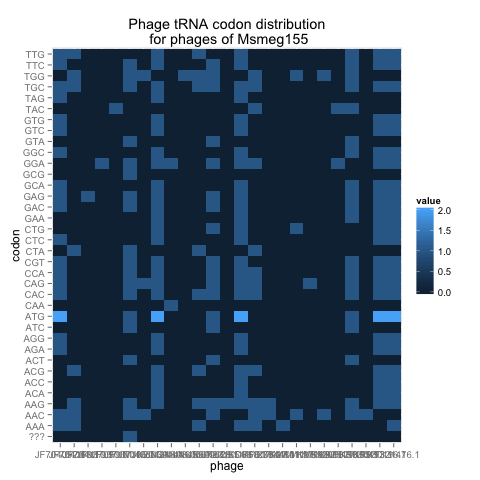

In [14]:
%%R -i smegs
###Look through tRNA content and select phages with unique tRNA profiles

phagelist<-smegs

codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

for (phage in phagelist){
    trna<-read.table(paste("./data/pgenomes/MSmeg_phages/", phage, ".trna",sep=""), skip=3, header=FALSE,sep="\t")
    trna%>%group_by(V6)%>%summarise(count=n())->trna
    colnames(trna)[2]<-phage
    codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)
}


codons$V1<-NULL
codons[is.na(codons)]<-0
rownames(codons)<-codons$V6
codons$V6<-NULL

members<-t(as.matrix(codons))
unique_trnas<-rownames(unique(members))
unique_trna_profiles<-unique(members)
print(nrow(members))
print(nrow(unique(members)))
print(data.frame(rowSums(unique_trna_profiles)))
t(unique_trna_profiles[,which(colSums(unique_trna_profiles)>0)])%>%.[,order(colSums(.))]->trnas2
trnas2%>%melt%>%ggplot(aes(X2, X1))+geom_tile(aes(fill=value))+labs(title="Phage tRNA codon distribution\n for phages of Msmeg155", x="phage", y="codon")

In [45]:
%%R 

#look at changes in tAI values for different genes based on combining phage and host tRNA content:
#plot out shift in tAI of host genes based on host-supplied tRNAs, and then combined phage and host tRNAs



Host_tais<-calculate_tai("./data/svm1/Msmeg155.trna", "./data/svm1/Msmeg155.cds.m")
tai_change<-vector(length=length(Host_tais))

tai_resid<-vector(length=length(Host_tais))

for (i in unique_trnas){
    ptrna<-paste("./data/pgenomes/MSmeg_phages/",i,".trna",sep="")
    htrna<-"./data/svm1/Msmeg155.trna"
    codonm<-"./data/svm1/Msmeg155.cds.m"
    p<-calculate_ph_tai(ptrna, htrna, codonm)
    linmod<-lm(p~Host_tais)
    resids<-resid(linmod)
    tai_resid<-cbind.data.frame(tai_resid, resids)
    colnames(tai_resid)[ncol(tai_resid)]<-i
}

[1] "scanning codonM file"
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items
Read 408273 items


Loading required package: grid
Loading required package: scales
Loading required package: proto


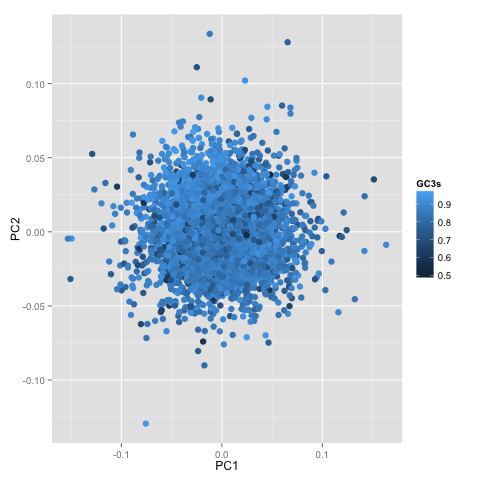

In [46]:
%%R
library(ggfortify)
syn_w<-read.table("./data/svm1/Msmeg155.w", header=TRUE, sep="\t", na.strings="*****")
rownames(syn_w)<-syn_w$title
rownames(tai_resid)<-syn_w$title
tai_resid$tai_resid<-NULL

tai_resid$tai_resid<-NULL
tr_pca<-prcomp(tai_resid)
autoplot(tr_pca, labels=TRUE, size=3, data=syn_w, col="GC3s")

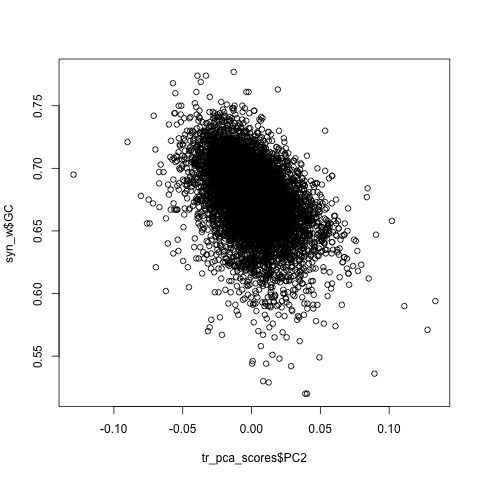

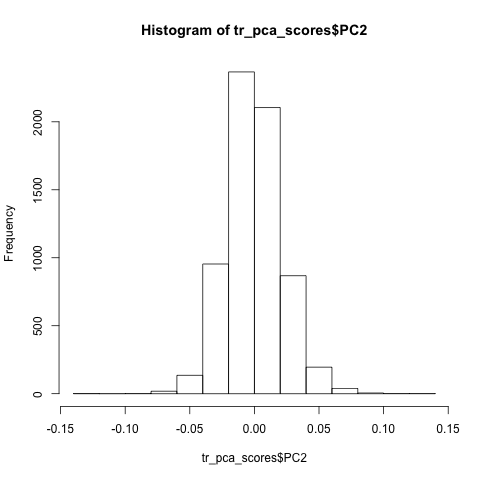

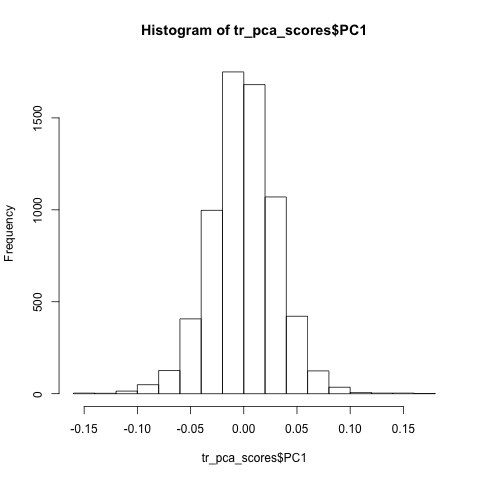

In [49]:
%%R
tr_pca_scores<-tr_pca$x%>%data.frame
tr_pca_scores$title<-rownames(tr_pca_scores)
tr_pca_scores$title<-gsub(" ","",tr_pca_scores$title)
plot(tr_pca_scores$PC2, syn_w$GC, type="p")


hist(tr_pca_scores$PC2)
hist(tr_pca_scores$PC1)

Read 408273 items
[1] "Here's a summary of the codons targeted by various phage tRNAs:"
   codon aa codon_prop Host_trnas phage_trna_total
1    AAA  K 0.18046185          1                7
2    AAC  N 0.88624543          1               11
3    AAG  K 0.81953815          1               12
5    ACA  T 0.06783496          1                4
6    ACC  T 0.58644203          1                4
7    ACG  T 0.31616973          1                7
8    ACT  T 0.02955328          0                3
9    AGA  R 0.01535288          1                5
11   AGG  R 0.04214050          1                5
14   ATC  I 0.93658688          1                3
15   ATG  M 1.00000000          3               13
17   CAA  Q 0.14041356          1                1
18   CAC  H 0.81353284          1               10
19   CAG  Q 0.85958644          1               11
21   CCA  P 0.05523552          1                9
28   CGT  R 0.12613940          1                8
29   CTA  L 0.01022377          1            

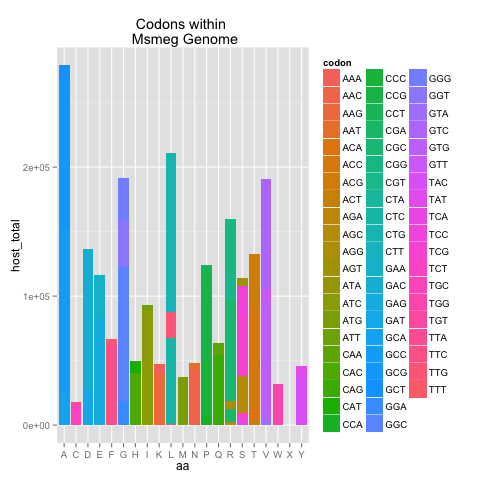

In [8]:
%%R -i smegs
codon_w<-read.table("./data/svm1/Msmeg155.w", header=TRUE, sep="\t", na.strings="*****")
codonm<-"./data/svm1/Msmeg155.cds.m"%>%scan%>%matrix(ncol=61, byrow=T)
rownames(codonm)<-codon_w$title

ccn<-read.table("./scripts/codonR/codonm_colnames.txt", sep="\t")
colnames(codonm)<-ccn$V2


codon_totals<-data.frame(colSums(codonm))
codon_totals$codon<-rownames(codon_totals)
colnames(codon_totals)[1]<-"HostTotal"
head(codon_totals)

ac_table<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")
ac_codons<-filter(ac_table, exact==1)
ac_codons$host_total<-codon_totals$HostTotal[match(ac_codons$codon, codon_totals$codon)]
ac_codons%>%group_by(aa)%>%summarise(total_aa_codons=sum(host_total))->aa_summary

ggplot(ac_codons, aes(aa, host_total, fill=codon))+geom_bar(stat="identity")+guides(fill=guide_legend(ncol=3))->Gcodonplot
Gcodonplot+labs(title="Codons within \n Msmeg Genome")->Gcodonplot
plot(Gcodonplot)

codon_prop<-vector()
for (i in seq(1:nrow(ac_codons))){
    a=ac_codons[i,3]
    n=ac_codons[i,5]
    
    total=aa_summary$total_aa_codons[which(a==aa_summary$aa)]
    codon_prop=c(codon_prop, n/total)
    }
ac_codons<-cbind.data.frame(ac_codons, codon_prop)

###Look through tRNA content and select phages with unique tRNA profiles

codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

trna<-read.table("./data/svm1/Msmeg155.trna", skip=3, header=FALSE,sep="\t")
trna%>%group_by(V6)%>%summarise(count=n())->trna
colnames(trna)[2]<-"Host_trnas"
codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)

for (phage in smegs){
    trna<-read.table(paste("./data/pgenomes/MSmeg_phages/", phage, ".trna",sep=""), skip=3, header=FALSE,sep="\t")
    trna%>%group_by(V6)%>%summarise(count=n())->trna
    colnames(trna)[2]<-phage
    codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)
}

codons$V1<-NULL
codons[is.na(codons)]<-0
rownames(codons)<-codons$V6
codons$V6<-NULL

members<-t(as.matrix(codons))

utp<-data.frame(t(unique(members)))
utp$codon<-rownames(utp)

host_codon<-merge(ac_codons, utp, by="codon", all.x=TRUE)
phage_trna_total=vector()
for (i in seq(1:nrow(host_codon))){
    total_phage_trnas=sum(host_codon[i,8:ncol(host_codon)])
    phage_trna_total=c(phage_trna_total, total_phage_trnas)
    }

host_codon<-cbind.data.frame(host_codon, phage_trna_total)

#looking at a summary of tRNAs encoded by phages of Syn 7803
print("Here's a summary of the codons targeted by various phage tRNAs:")
host_codon[host_codon$phage_trna_total>0,c(1,3,6,7,ncol(host_codon))]%>%print
host_codon[host_codon$phage_trna_total>0,c(1,3,6,7,ncol(host_codon))]%>%nrow%>%print


In [9]:
%%R

format_codon_m<-function(codonm, codonw){
    codon_w<-read.table(codonw, header=TRUE, sep="\t", na.strings="*****")
    codonm<-codonm%>%scan%>%matrix(ncol=61, byrow=T)
    rownames(codonm)<-codon_w$title
    ccn<-read.table("./scripts/codonR/codonm_colnames.txt", sep="\t")
    colnames(codonm)<-ccn$V2
    return(codonm)
}

gptr<-function(codonlist, gene){
        anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
        codon_prop=vector()    
        codons_tested=vector()
        gene$codon<-rownames(gene)
        colnames(gene)[1]<-"count"
        merge(anti, gene, by="codon")->gene
        gene%>%filter(exact==1)%>%group_by(aa)%>%summarise(aa_count=sum(count))->aa_sum

        for (codon in codonlist){
            if (codon %in% gene$codon) {
            codons_tested=c(codons_tested, codon)
            a=gene$aa[which(codon==gene$codon)]
            n=gene$count[which(codon==gene$codon)]     #the number of exact match codons in the gene
            total=aa_sum$aa_count[which(a==aa_sum$aa)] #the total number of codons for the specific amino acid
            codon_prop=c(codon_prop, n/total)
        }}
        return(cbind.data.frame(codons_tested, codon_prop))
      }

Gptr<-function(codonlist, codonm){
    anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
    genome_codon_prop=vector()
    codons_tested=vector()
    genome<-data.frame(colSums(codonm))
    genome$codon<-rownames(genome)
    colnames(genome)[1]<-"count"

    merge(anti, genome, by="codon")->genome

    genome%>%group_by(aa)%>%summarise(aa_count=sum(count))->genome_aa_sum

    for (codon in codonlist){
        if (codon %in% genome$codon){
        codons_tested=c(codons_tested, codon)
        a=genome$aa[which(codon==genome$codon)]
        n=genome$count[which(codon==genome$codon)]     #the number of exact match codons in the gene
        total=genome_aa_sum$aa_count[which(a==genome_aa_sum$aa)] #the total number of codons for the specific amino acid
        genome_codon_prop=c(genome_codon_prop, n/total)
        }}
        output<-cbind.data.frame(codons_tested, genome_codon_prop)
        return(output)
        }


Read 408273 items


In [10]:
%%R

codonm<-format_codon_m("./data/svm1/Msmeg155.cds.m","./data/svm1/Msmeg155.w")
codonlist<-host_codon[host_codon$phage_trna_total>0,1]

Genome_rep<-Gptr(codonlist, codonm)
gene_ptcs<-vector()
for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codons_tested")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(Together$pig)
    gene_ptcs<-c(gene_ptcs, ptcs)
}
head(gene_ptcs)

Read 408273 items
[1] 0.9061942 1.4140754 0.7881613       NaN 1.0067834       NaN


[1] "the number of genes with a ptcs greater than three are: 0"
[1] "the number of genes with a ptcs greater than two are: 5"


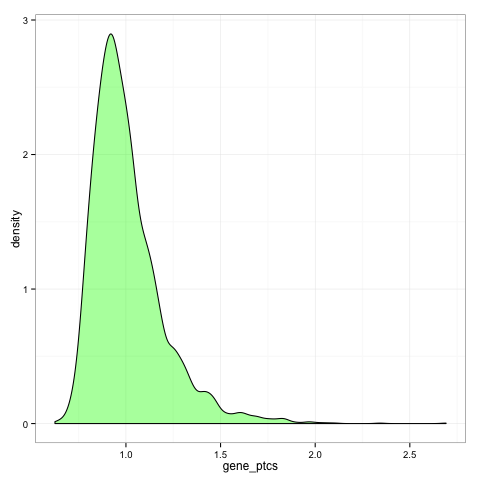

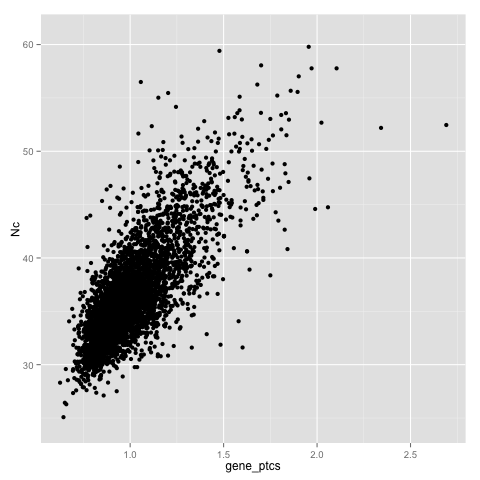

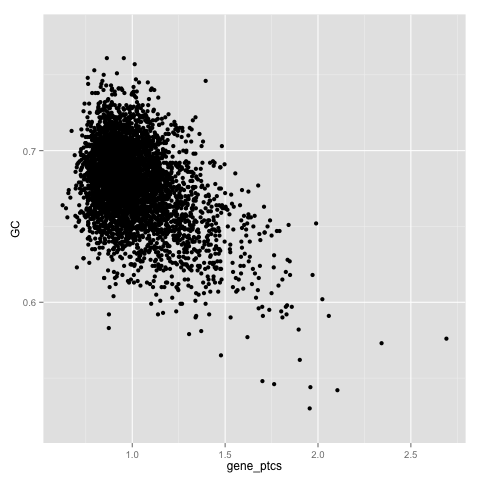

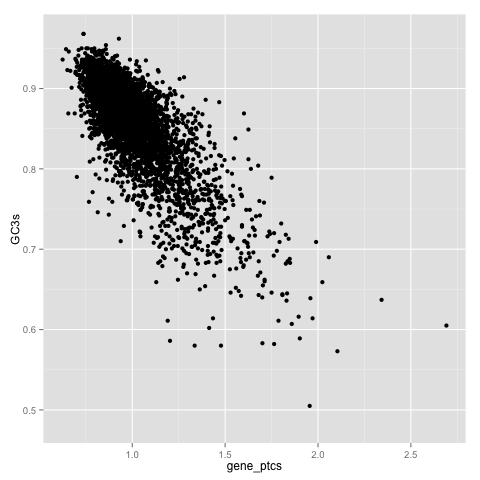

In [11]:
%%R
#Results:
host_w<-read.table("./data/svm1/Msmeg155.w", header=TRUE, sep="\t", na.strings="*****")
host_w$X<-NULL
cbind.data.frame(host_w, gene_ptcs)->host_w
print(paste("the number of genes with a ptcs greater than three are:", nrow(host_w[which(host_w$gene_ptcs>3),])))
print(paste("the number of genes with a ptcs greater than two are:", nrow(host_w[which(host_w$gene_ptcs>2),])))

#plots
ggplot(data.frame(gene_ptcs), aes(gene_ptcs))+geom_density(alpha=0.4, fill="green")+theme_bw()->f
plot(f)
ggplot(host_w, aes(gene_ptcs, Nc))+geom_point()->l
plot(l)
ggplot(host_w, aes(gene_ptcs,GC))+geom_point()->k
plot(k)
ggplot(host_w, aes(gene_ptcs,GC3s))+geom_point()->j
plot(j)

In [12]:
%%R
gene_order<-seq(1:nrow(host_w))
host_w<-cbind.data.frame(gene_order, host_w)
annotations<-read.csv("Msmeg_CDS_table.txt", header=TRUE, sep="\t")
host_w$title<-gsub(" ","",host_w$title)
annotations$title<-gsub(" ","",annotations$title)
host_w<-merge(host_w, annotations, by="title", all.x=TRUE)
host_w$cds_category<-"gene"
print(colnames(host_w))

[1] "title"        "gene_order"   "Nc"           "GC3s"         "GC"          
[6] "L_aa"         "gene_ptcs"    "product"      "cds_category"


Error in dev.off() : 
  QuartzBitmap_Output - unable to open file '/var/folders/nl/_s4dgtmd31v8khp6f6gd3kjc0000gn/T/tmpIJBteu/Rplots001.png'


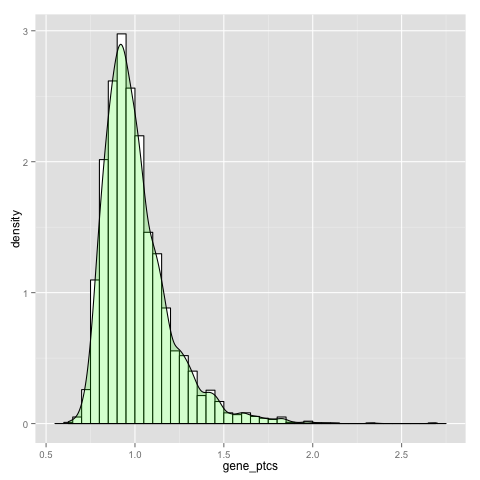

In [38]:
%%R
ggplot(host_w, aes(x=gene_ptcs))+geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
    binwidth=.05, colour="black", fill="white") + geom_density(alpha=.2, fill="green")->ptcs_hist
plot(ptcs_hist)

In [16]:
%%R
library(parody)
host_w$ptcs

NULL


In [18]:
%%R
outliers<-calout.detect(na.omit(host_w$gene_ptcs), alpha=0.01, method="boxplot")
host_w[outliers$ind,8]

 [1] hypothetical protein                                                                                      
 [2] Short-chain dehydrogenase/reductase SDR                                                                   
 [3] hypothetical protein                                                                                      
 [4] Putative cation antiporter NADH dehydrogenase subunit                                                     
 [5] Putative cation antiporter NADH dehydrogenase subunit                                                     
 [6] Monooxygenase FAD-binding protein                                                                         
 [7] Putative signal transduction protein with CBS domains                                                     
 [8] Transcriptional regulator, TetR family                                                                    
 [9] Conserved ATPase                                                                                   

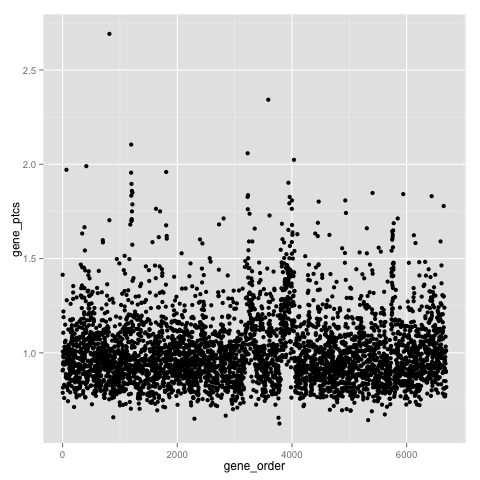

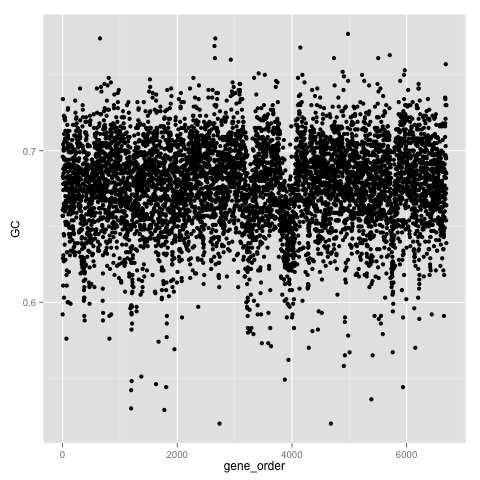

In [12]:
%%R
#Where do high pcts scoring genes fall in the genome?
ggplot(host_w, aes(gene_order, gene_ptcs))+geom_point()->b
plot(b)
ggplot(host_w, aes(gene_order, GC))+geom_point()->bb
plot(bb)

In [13]:
%%R
print(data.frame(host_w[which(host_w$gene_ptcs>1.5),7]))

                                             host_w.which.host_w.gene_ptcs...1.5...7.
1                             Conserved hypothetical alanine and proline rich protein
2                                           Conserved MCE associated membrane protein
3                                                                                 Fmt
4                                                           integral membrane protein
5                                                                hypothetical protein
6                                                                hypothetical protein
7                                                                hypothetical protein
8                                                                hypothetical protein
9                                                                hypothetical protein
10                                                                      Peptidase C26
11                                                    